# Covid 19 Analysis

In [92]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 3) Prediction and Regression
#### 3.1) Random Forest
- - -

In [93]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered
0,Afghanistan,33.000000,0.373184,65.000000,0.232525,2020-01-22,0,0.000000,0,0,0.0
1,Albania,41.153300,0.505218,20.168300,-0.071789,2020-01-22,0,0.000000,0,0,0.0
2,Algeria,28.033900,0.292763,1.659600,-0.197424,2020-01-22,0,0.000000,0,0,0.0
3,Andorra,42.506300,0.527128,1.521800,-0.198359,2020-01-22,0,0.000000,0,0,0.0
4,Angola,-11.202700,-0.342631,17.873900,-0.087363,2020-01-22,0,0.000000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22679,West Bank and Gaza,31.952200,0.356216,35.233200,0.030471,2020-05-07,106,0.990654,375,2,176.0
22680,Western Sahara,24.215500,0.230928,-12.885800,-0.296157,2020-05-07,106,0.990654,6,0,5.0
22681,Yemen,15.552727,0.090644,48.516388,0.120636,2020-05-07,106,0.990654,25,5,1.0
22682,Zambia,-15.416700,-0.410872,28.283300,-0.016705,2020-05-07,106,0.990654,153,4,103.0


In [94]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.37318385,  0.23252495,  0.        ],
       [ 0.50521768, -0.0717886 ,  0.        ],
       [ 0.29276326, -0.19742399,  0.        ],
       ...,
       [ 0.09064424,  0.12063567,  0.990654  ],
       [-0.41087195, -0.01670471,  0.990654  ],
       [-0.4850935 , -0.0050519 ,  0.990654  ]])

#### 3.1.1) Regression for Confirmed Cases
- - -

In [95]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([  0,   0,   0, ...,  25, 153,  34])

In [96]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.20, shuffle=False)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [97]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [98]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
rf_estimator = search.best_estimator_
# rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      # max_depth=100, max_features=3, max_leaf_nodes=None,
                      # max_samples=None, min_impurity_decrease=0.0,
                      # min_impurity_split=None, min_samples_leaf=3,
                      # min_samples_split=8, min_weight_fraction_leaf=0.0,
                      # n_estimators=100, n_jobs=None, oob_score=False,
                      # random_state=None, verbose=0, warm_start=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.7min finished


Best score: -238880166.58820167
Best parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}


MAE: 5688.10121650943
MSE: 1272438702.2557807


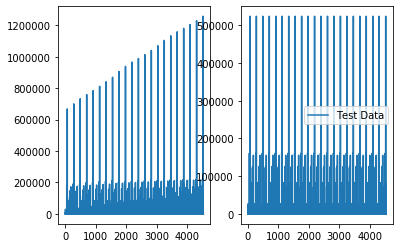

In [87]:
rf_estimator.fit(in_conf_train, out_conf_train) # tirar quando descomentar o que esta em cima
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.subplot(1, 2, 1)
plt.plot(out_conf_test)
plt.subplot(1, 2, 2)
plt.plot(rf_estimator_pred)
plt.legend(['Test Data', 'Random Forest Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))

In [ ]:
model_accuracies = []

# range estava a 1000
for repetition in range(200):
    (accuracy_in_train,
     accuracy_in_test,
     accuracy_out_train,
     accuracy_out_test) = train_test_split(inputs, outputs, test_size=0.25)
    
    rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
    rfr.fit(accuracy_in_train, accuracy_out_train)
    classifier_accuracy = rfr.score(accuracy_in_test, accuracy_out_test)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)

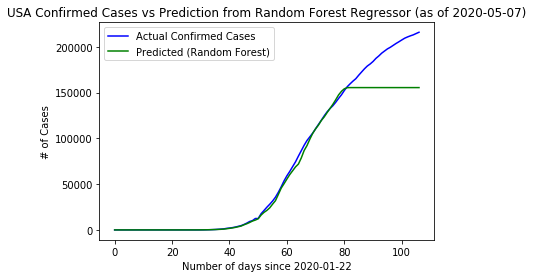

In [88]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [89]:
# do model with non normalized values, for comparison
inputs_non_norm = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs_non_norm

array([[ 33.      ,  65.      ,   0.      ],
       [ 41.1533  ,  20.1683  ,   0.      ],
       [ 28.0339  ,   1.6596  ,   0.      ],
       ...,
       [ 15.552727,  48.516388, 106.      ],
       [-15.4167  ,  28.2833  , 106.      ],
       [-20.      ,  30.      , 106.      ]])

In [90]:
# divide in training and testing sets
non_norm_in_conf_train, non_norm_in_conf_test, non_norm_out_conf_train, non_norm_out_conf_test = train_test_split(inputs_non_norm, outputs, test_size=0.25, shuffle=True)

In [91]:
# create Random Forest Regressor instance, and check the hyper parameters
rf_non_norm = RandomForestRegressor()
rf_non_norm.get_params()

# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# search_non_norm = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search_non_norm = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

search_non_norm.fit(non_norm_in_conf_train, non_norm_out_conf_train)
print('Best score: {}'.format(search_non_norm.best_score_))
print('Best parameters: {}'.format(search_non_norm.best_params_))
search_non_norm.best_estimator_
rf_estimator_non_norm = search_non_norm.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.0min finished


Best score: -20257674.95280801
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 80, 'bootstrap': True}


In [45]:
# rf_estimator_non_norm.fit(non_norm_in_conf_train, non_norm_out_conf_train)
rf_estimator_pred_non_norm = rf_estimator_non_norm.predict(non_norm_in_conf_test)
plt.plot(non_norm_out_conf_test)
plt.plot(rf_estimator_pred_non_norm)
plt.legend(['Test Data', 'Random Forest Predictions (Non Normalized)'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

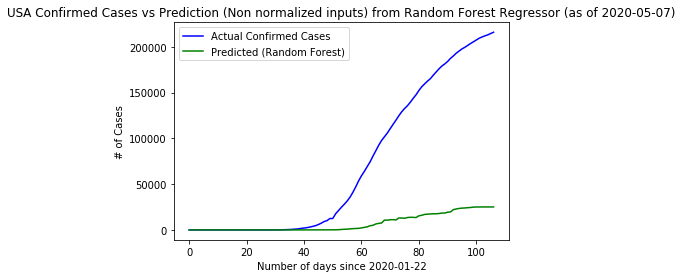

In [48]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs_non_norm = usa_df[["Lat", "Long", "Num_days_from_begin"]].values
usa_pred_output_non_norm = rf_estimator_non_norm.predict(usa_inputs_non_norm)

plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output_non_norm, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction (Non normalized inputs) from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [22]:
usa_pred_output[79:]

array([364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697,
       364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697,
       364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697,
       364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697,
       364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697,
       364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697,
       364606.91147697, 364606.91147697, 364606.91147697, 364606.91147697])